In [4]:
# Importing Libraries
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.optimize import minimize
from scipy import integrate
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
import requests
import lmfit
from lmfit import minimize, Parameters, Parameter, report_fit
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

In [5]:
!pip install sqlalchemy
import pandas as pd
from sqlalchemy import create_engine

In [6]:
# Importing Data
WA_Cov1 = pd.read_csv('WA-COVID-19.csv', usecols=['Number of days','Seasons','Total Population', 'Number of Infected People','Number of deaths', 'recovered'])
WA_Cov1.set_index('Number of days')
WA_Cov1.dtypes  

Number of days                int64
Seasons                      object
Total Population              int64
Number of deaths              int64
Number of Infected People     int64
recovered                     int64
dtype: object

In [7]:
WA_Cov1.head()

,Number of days,Seasons,Total Population,Number of deaths,Number of Infected People,recovered
0,0,WINTER,7705281,0,0,0
1,1,WINTER,7705281,0,0,0
2,2,WINTER,7705281,0,0,0
3,3,WINTER,7705281,0,0,0
4,4,WINTER,7705281,0,0,0


In [8]:
# check to see how many null objects we have
WA_Cov1.isnull().sum()

Number of days               0
Seasons                      0
Total Population             0
Number of deaths             0
Number of Infected People    0
recovered                    0
dtype: int64

In [9]:
WA_Cov1['recovered'] = WA_Cov1['recovered'].fillna(0)

In [10]:
# check to see how many null objects we have
WA_Cov1.isnull().sum()

Number of days               0
Seasons                      0
Total Population             0
Number of deaths             0
Number of Infected People    0
recovered                    0
dtype: int64

In [11]:
# summary of each column in the dataframe
WA_Cov1['Number of Infected People'].describe()

count       420.000000
mean     100386.733333
std      107857.787203
min           0.000000
25%       14269.500000
50%       65411.000000
75%      157813.500000
max      344532.000000
Name: Number of Infected People, dtype: float64

In [12]:
WA_Cov1['Number of deaths'].describe()

count     420.000000
mean     1833.840476
std      1412.124752
min         0.000000
25%       746.250000
50%      1688.000000
75%      2619.000000
max      5041.000000
Name: Number of deaths, dtype: float64

In [13]:
WA_Cov1['recovered'].describe()

count    420.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: recovered, dtype: float64

In [14]:
WA_Cov1['Total Population'].describe()

count    4.200000e+02
mean    -1.626174e+06
std      1.161140e+07
min     -3.522736e+07
25%     -6.600096e+06
50%      3.678638e+06
75%      7.342662e+06
max      7.705281e+06
Name: Total Population, dtype: float64

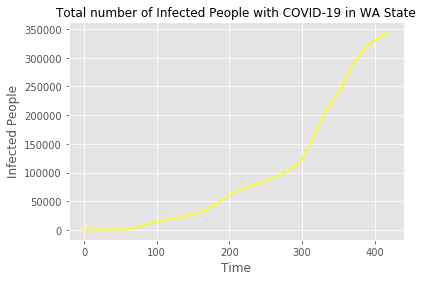

In [15]:
# A graph showing Infected people in WA State
plt.plot(WA_Cov1['Number of days'],WA_Cov1['Number of Infected People'],color='yellow')
plt.title('Total number of Infected People with COVID-19 in WA State',fontsize=12)
plt.xlabel('Time')
plt.ylabel('Infected People')
plt.show()

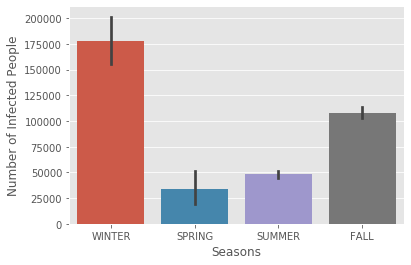

In [16]:
sns.barplot(x="Seasons", y="Number of Infected People", data=WA_Cov1)

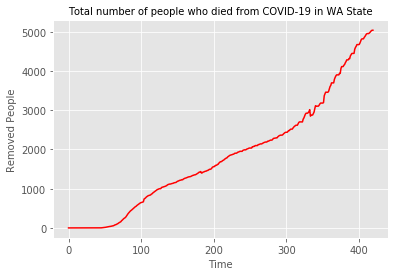

In [17]:
# A graph showing Dead people in WA State
plt.plot(WA_Cov1['Number of days'],WA_Cov1['Number of deaths'],color='red')
plt.title('Total number of people who died from COVID-19 in WA State',fontsize=10)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Removed People',fontsize=10)
plt.show()

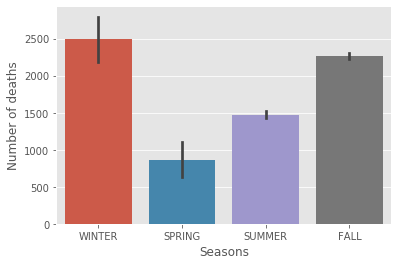

In [18]:
sns.barplot(x="Seasons", y="Number of deaths", data=WA_Cov1)

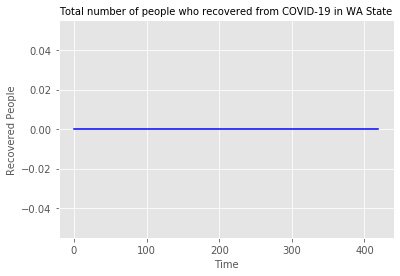

In [19]:
# A graph showing Recovered people in WA State
plt.plot(WA_Cov1['Number of days'],WA_Cov1['recovered'],color='blue')
plt.title('Total number of people who recovered from COVID-19 in WA State',fontsize=10)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Recovered People',fontsize=10)
plt.show()

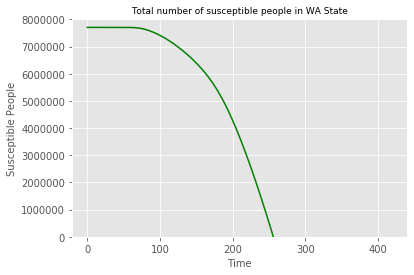

In [20]:
# A graph showing Susceptible people in WA State
plt.plot(WA_Cov1['Number of days'],WA_Cov1['Total Population'],color='green')
plt.title('Total number of susceptible people in WA State',fontsize=9)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Susceptible People',fontsize=10)
plt.ylim(0,8000000)
plt.show()

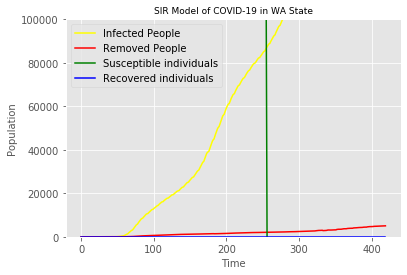

In [21]:
# Plot a simple line chart
plt.plot(WA_Cov1['Number of days'], WA_Cov1['Number of Infected People'], color='yellow', label='Infected People')

# Plot another line on the same chart/graph
plt.plot(WA_Cov1['Number of days'], WA_Cov1['Number of deaths'], color='red', label='Removed People')

# Plot another line on the same chart/graph
plt.plot(WA_Cov1['Number of days'], WA_Cov1['Total Population'], color='green', label='Susceptible individuals')
plt.ylim(0,100000)

# Plot another line on the same chart/graph
plt.plot(WA_Cov1['Number of days'], WA_Cov1['recovered'], color='blue', label='Recovered individuals')
plt.title('SIR Model of COVID-19 in WA State',fontsize=9)
plt.xlabel('Time',fontsize=10)
plt.ylabel('Population',fontsize=10)
plt.legend()
plt.show()

In [22]:
def ode_model(z, t, alpha, beta):
    S, I, R = z
    N = S + I + R 
    dSdt = -beta/N*S*I
    dIdt = beta*S*I - alpha*I
    dRdt = alpha*I
    return [dSdt, dIdt, dRdt]

In [23]:
def ode_solver(t, initial_conditions, params):
    initI, initS, initR, initN = initial_conditions
    alpha, beta = params['alpha'].value, params['beta'].value
    initS = initN - (initI + initR)
    res = odeint(ode_model, [initS, initI, initR], t, args=(alpha, beta))
    return res

In [24]:
initN = 7000000
initS = 300000
initI = 1000
initR = 0
R0 = 1/14
alpha = 0.000005
beta = R0 * alpha
days = 420

params = Parameters()
params.add('alpha', value=alpha, min=0, max=10)
params.add('beta', value=beta, min=0, max=10)

In [25]:

def main(initI, initR, initN, initS, alpha, beta, days, param_fitting):
    initial_conditions = [initS, initI, initR, initN]
    params['alpha'].value, params['beta'].value = [alpha, beta]
    tspan = np.arange(0, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    S,I,R= sol[:, 0], sol[:, 1], sol[:, 2]
    
    # Create traces
    fig = go.Figure()
    if not param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=S, mode='lines+markers', name='Susceptible'))
    fig.add_trace(go.Scatter(x=tspan, y=I, mode='lines+markers', name='Infected'))
    fig.add_trace(go.Scatter(x=tspan, y=R, mode='lines+markers',name='Recovered'))
    if param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.infected, mode='lines+markers',\
                             name='Infections Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.discharged, mode='lines+markers',\
                             name='Recovered Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.deaths, mode='lines+markers',\
                             name='Deaths Observed', line = dict(dash='dash')))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig.update_layout(title='Simulation of SEIRD Model',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/seird_simulation.png")
    fig.show()

In [26]:
def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:, 2:5] - data).ravel()

In [27]:
initial_conditions = [initS, initI, initR, initN]
alpha = 0.000005
beta = R0 * alpha
params['alpha'].value = alpha
params['beta'].value = beta
days = 420
tspan = np.arange(0, days, 1)
data = WA_Cov1.loc[0:(days-1), ['Number of Infected People', 'Number of deaths']].values

In [28]:
data.shape

(420, 2)

In [29]:
params

name,value,initial value,min,max,vary
alpha,5.0000e-06,5e-06,0.00000000,10.0000000,True
beta,3.5714e-07,3.5714285714285716e-07,0.00000000,10.0000000,True


In [31]:

# fit model and find predicted values
result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')
# result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq', \
# **{'xtol':1.e-15, 'ftol':1.e-15}

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [ ]:
result.params

In [ ]:
# display fitted statistics
report_fit(result)

In [ ]:
final = data + result.residual.reshape(data.shape)

fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan, y=data[:, 0], mode='markers', name='Observed Infections', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=data[:, 1], mode='markers', name='Observed Removed', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 0], mode='lines+markers', name='Fitted Infections'))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 1], mode='lines+markers', name='Fitted Removed'))
fig.update_layout(title='SIR: Observed vs Fitted',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=1000, height=600
                     )

In [ ]:
observed_IRD = WA_Cov1.loc[:, ['Number of Infected People', 'Number of deaths']].values
print(observed_IRD.shape)

In [ ]:
tspan_fit_pred = np.arange(0, observed_IRD.shape[0], 1)
params['alpha'].value = result.params['alpha'].value
params['beta'].value = result.params['beta'].value
fitted_predicted = ode_solver(tspan_fit_pred, initial_conditions, params)

In [ ]:
fitted_predicted_IRD = fitted_predicted[:, 2:5]
print(fitted_predicted_IRD.shape)

In [ ]:
print("Fitted MAE")
print('Infected: ', np.mean(np.abs(fitted_predicted_IRD[:days, 0] - observed_IRD[:days, 0])))
#print('Recovered: ', np.mean(np.abs(fitted_predicted_IRD[:days, 1] - observed_IRD[:days, 1])))
#print('Dead: ', np.mean(np.abs(fitted_predicted_IRD[:days, 2] - observed_IRD[:days, 2])))

print("\nFitted RMSE")
print('Infected: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 0] - observed_IRD[:days, 0])**2)))
#print('Recovered: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 1] - observed_IRD[:days, 1])**2)))
#print('Dead: ', np.sqrt(np.mean((fitted_predicted_IRD[:days, 2] - observed_IRD[:days, 2])**2)))

In [ ]:
print("Predicted MAE")
print('Infected: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 0] - observed_IRD[days:, 0])))
#print('Recovered: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 1] - observed_IRD[days:, 1])))
#print('Dead: ', np.mean(np.abs(fitted_predicted_IRD[days:observed_IRD.shape[0], 2] - observed_IRD[days:, 2])))

print("\nPredicted RMSE")
print('Infected: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 0] - observed_IRD[days:, 0])**2)))
#print('Recovered: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 1] - observed_IRD[days:, 1])**2)))
#print('Dead: ', np.sqrt(np.mean((fitted_predicted_IRD[days:observed_IRD.shape[0], 2] - observed_IRD[days:, 2])**2)))

In [ ]:

interact(main, 
         initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, layout=slider_layout),
         initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, layout=slider_layout),
         initN=IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, layout=slider_layout),
         beta=FloatSlider(min=0, max=4, step=0.01, value=result.params['beta'].value, description='Infection rate', style=style, layout=slider_layout),
         sigma=FloatSlider(min=0, max=4, step=0.01, value=result.params['sigma'].value, description='Incubation rate', style=style, layout=slider_layout),
         gamma=FloatSlider(min=0, max=4, step=0.01, value=result.params['gamma'].value, description='Recovery rate', style=style, layout=slider_layout),
         mu=FloatSlider(min=0, max=1, step=0.01, value=result.params['mu'].value, description='Mortality rate', style=style, layout=slider_layout),
         days=IntSlider(min=1, max=600, step=7, value=240, description='Days', style=style, layout=slider_layout),
         param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=True, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );

In [ ]:
from scipy.interpolate import CubicSpline, interp1d
plt.rcParams['figure.figsize'] =(12,8)

# apply cubic spline interpolation
cs = CubicSpline(WA_Cov1["Number of days"],WA_Cov1["Number of Infected People"] )  
  
# plot cubic spline interpolation
plt.plot(WA_Cov1["Number of days"],WA_Cov1["Number of Infected People"], 'o', label='Infected People',color='yellow')
plt.plot(WA_Cov1['Number of days'], WA_Cov1['Number of Infected People'], color='black', label='Infected People')
plt.ylim(0, 400000)
plt.legend(loc='upper right', ncol=2)
plt.title('Cubic Spline Interpolation for the Infected People with COVID-19 in WA')
plt.show()

In [ ]:
# apply cubic spline interpolation
cs = CubicSpline(WA_Cov1["Number of days"],WA_Cov1["Number of deaths"] )  
  
# plot cubic spline interpolation
plt.plot(WA_Cov1["Number of days"],WA_Cov1["Number of deaths"], 'o', label='Removed People')
plt.plot(WA_Cov1['Number of days'], WA_Cov1['Number of deaths'], color='black', label='Removed People')
plt.ylim(0, 4000)
plt.legend(loc='upper right', ncol=2)
plt.title('Cubic Spline Interpolation for the Removed People with COVID-19 in WA')
plt.show()

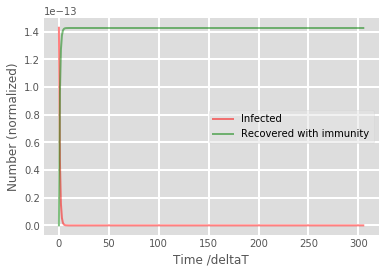

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, integrate


# The SIR model differential equations.
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# The fit integration.
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(N, beta, gamma))[:,1]


# function for genetic algorithm to minimize (sum of squared error)
# bounds on parameters are set in generate_Initial_Parameters() below
def sumOfSquaredError(parameterTuple):
    return np.sum((ydata - fit_odeint(xdata, *parameterTuple)) ** 2)


def generate_Initial_Parameters():
    parameterBounds = []
    parameterBounds.append([-0.1, 10.0])  # parameter bounds for beta
    parameterBounds.append([-0.1, 20.0])  # parameter bounds for gamma
    parameterBounds.append([-0.1, 0.1])  # parameter bounds for mu

    # "seed" the numpy random number generator for repeatable results
    result = optimize.differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x


if __name__ == "__main__":

    ########################################
    # Get data to be fitted from the model #
    ########################################
    # Total population, N.
    N = 7000000
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1e-6, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/deltaT).
    beta, gamma = -0.001524766068089,   1.115130184090387
    # A grid of time points (in deltaT increment)
    t = np.linspace(0, 305, 306)

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = integrate.odeint(sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    # ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /deltaT')
    ax.set_ylabel('Number (normalized)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

    #####################################
    # Fit the data using the same model #
    #####################################

    # Define the "experimental" data
    ydata = WA_Cov1['Number of Infected People']
    xdata = WA_Cov1['Number of days']

    # Define the initial conditions vector, note that this will be equal to y0 above.
    I0, R0 = ydata[0], 0
    S0 = N - I0 - R0

    # generate initial parameter values
    initialParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, p0=tuple(initialParameters),
                                                bounds=([-0.1, 0., -np.inf], np.inf))

    # create values for display of fitted peak function
    b, g, m = fittedParameters
    ret = integrate.odeint(sir_model, y0, t, args=(N, b, g))
    S, I, R = ret.T

    plt.plot(xdata, ydata)  # plot the raw data
    plt.plot(xdata, I, linestyle='--')  # plot the equation using the fitted parameters
    plt.show()

    psig = np.sqrt(np.diag(pcov))
    print('Initial parameters:')
    print(f'beta : {initialParameters[0]}\n'
          f'gamma: {initialParameters[1]}\n')
    print('Fitted parameters:')
    print(f'beta : {fittedParameters[0]} (+/- {psig[0]})\n'
          f'gamma: {fittedParameters[1]} (+/- {psig[1]})\n')
    